In [13]:
from math import log
from pathlib import Path
from copy import deepcopy

import pandas as pd
from tqdm import tqdm

import torch 
torch.manual_seed(2)

import numpy as np
np.random.seed(2)

from scipy.stats import mannwhitneyu

from skimage.measure import marching_cubes

import matplotlib.pyplot as plt
plt.rcParams['font.family']= 'open sans'

from mpl_toolkits.mplot3d.art3d import Poly3DCollection


from rdn.defaults import (default_goda_transformation,
                          stripplot,
                          pd_bin_by_distance,
                          mean_is_distance
                          )

from rdn.fitting.models import LocalGaussModelTilde
from rdn.defaults import pardict_from_result
from rdn.validation import Simulation



Parameters

In [14]:
T = [-15,-10,-5,2,10,20,30,40]
sT = [2, 10, 20, 30, 40]
osT = torch.arange(2,20)
nss = 7
time_col = 'norm_2'

Goda Data

In [15]:
df = pd.read_pickle(
    'data/raw_data/raw_goda_data.pkl'
)

df = default_goda_transformation(df)
df = df[df['nss']==nss]

cols = ['norm_-15', 'norm_-10', 'norm_-5', 'norm_2', 'norm_10', 'norm_20', 'norm_30','norm_40']

# Select the drugs
cdf = df[df['drug'] == 'Control']
Yc = cdf[cdf['type']=='Stim'][cols].mean()
Yc_sem = cdf[cdf['type']=='Stim'][cols].sem()

fkdf = df[df['drug'] == 'Calcineurin']
Yfk = fkdf[fkdf['type']=='Stim'][cols].mean()
Yfk_sem = fkdf[fkdf['type']=='Stim'][cols].sem()

aipdf = df[df['drug'] == 'CamKII']


/home/janko/code/phd/rdn-project/test-env/lib/python3.13/site-packages/rdn/defaults/defaultgodatransformation.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['nss'].replace({
/home/janko/code/phd/rdn-project/test-env/lib/python3.13/site-packages/rdn/defaults/defaultgodatransformation.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_op

Onuma data

In [16]:
codf = pd.read_csv('data/validation_data/onuma_data/control.csv',
                 names=['T', 'Y', 'Y_sem'])
fkodf = pd.read_csv('data/validation_data/onuma_data/fk506.csv',
                    names=['T', 'Y', 'Y_sem'])

codf = codf[codf['T']<50]
fkodf = fkodf[fkodf['T']<50].iloc[2:].sort_values(by='T')

codf[['Y', 'Y_sem']] /= 100
fkodf[['Y', 'Y_sem']] /= 100

In [17]:
def get_plot_series_from_df(df, bins, t_idx):
    '''Auxiliary function to get the data to plot from the experimental
    dataframe
    '''
    dff = df[(df['nss'] == -1) & (df['distance'] < 15)]

    # Take out the stimulated statistics
    sdff = dff[dff['type']=='Stim'][f'norm_{t_idx}']
    s_median = sdff.median()
    s_q1 = sdff.quantile(q=0.25)
    s_q3 = sdff.quantile(q=0.75)


    # Now the unstim binning
    dff = dff[dff['type']=='Spine']
    dff['Y'] = dff[f'norm_{t_idx}']

    dff['bin'] = pd.cut(dff['distance'], bins)
    tdff = dff[['bin','Y']]
    b_dff = dff.groupby('bin').agg({'distance' : 'mean', 'Y' : ['median']})
    b_dff['Y','q1'] = tdff.groupby('bin').quantile(q=0.25)
    b_dff['Y','q3'] = tdff.groupby('bin').quantile(q=0.75)
    b_dff.reset_index(drop=True, inplace=True)

    # Add the stimulated bin again
    b_dff.loc[10] = [0, s_median, s_q1, s_q3]

    # Take the plotting data
    X_data = b_dff['distance', 'mean']
    Y_data = b_dff['Y', 'median']
    Y_q1_data = b_dff['Y', 'q1']
    Y_q3_data = b_dff['Y', 'q3']

    Y_el_data = Y_data-Y_q1_data
    Y_eh_data = Y_q3_data-Y_data

    return X_data, Y_data, Y_el_data, Y_eh_data


def get_plot_series_from_simulation(rel_sizes_batch, lr, ur, stim_idx, t_idx):
    '''Auxiliary function to get the data to plot from the experimental
    dataframe.
    Notice that it returns not the errors but the 1 and 3 quantiles, since they
    will be used with fillbetween
    '''

    
    # Extract data for plotting
    X = np.arange(-lr, ur)
    Y_batch = rel_sizes_batch[t_idx, stim_idx-lr:stim_idx+ur]
    Y, _ = Y_batch.median(axis=1)
    Y_1q = torch.quantile(Y_batch, 0.25, axis=1)
    Y_3q = torch.quantile(Y_batch, 0.75, axis=1)

    return X, Y, Y_1q, Y_3q


# Transform in percentages
def ttp(*data):
    '''transform to percentages'''
    res = []
    for d in data:
        res.append(d*100)
    return res

def ttc(*data):
    '''transform to changes'''
    res = []
    for d in data:
        res.append(d-1.)
    return res

def plot_prediction_plot(ax, df, rel_sizes_batch, bins, lr, ur, stim_idx, t_idx,
                         **kwargs):
    '''The main plot function (plots the classic prediction vs data)'''

    # Pure data
    dff = df[(df['nss'] == -1) & (df['distance'] < 15)]
    ax.scatter(dff['distance'], dff[f'norm_{t_idx}']-1, alpha=0.1, c='gray',
               linewidths=0, s=kwargs.get('s'),)


    # Binned data
    X_data, Y_data, Y_el_data, Y_eh_data = get_plot_series_from_df(df, bins, t_idx) 

    Y_data, _ = ttc(Y_data,1)

    ax.errorbar(X_data,
                Y_data,
                yerr=(Y_el_data, Y_eh_data),
                fmt='.', 
                c='black',
                markersize=kwargs.get('markersize'),
                capsize=kwargs.get('capsize'),
                linewidth=1,
                label=r'Experiment',
                zorder=100,
                )
                

    # Prediction
    X, Y, Y_1q, Y_3q = get_plot_series_from_simulation(rel_sizes_batch,
                                                       lr,
                                                       ur,
                                                       stim_idx, 
                                                       t_idx)
    Y, Y_1q, Y_3q = ttc(Y, Y_1q, Y_3q)

    ax.plot(X, Y, linewidth=kwargs.get('linewidth'),
            label=r'Prediction')
    ax.fill_between(X, Y_1q, Y_3q, alpha=0.1)
    ax.axhline(y=0, linewidth=1, linestyle=(0,(5,5)), c='black')


def plot_distribution_plot(axs, df, rel_sizes_batch, stim_idx, t_idx):

    bins = 20

    ## Right panel, upper
    ax = axs[0]
    ax.hist(rel_sizes_batch[t_idx, stim_idx,:].flatten()-1, 
            bins=bins,
            density=True,
            label='Prediction',
            )

    ## Right panel, lower
    ax = axs[1]
    dff = df[(df['nss'] == -1) & (df['distance'] < 15)]
    sdff = dff[dff['type']=='Stim'][f'norm_{t_idx}']

    Y = (sdff-1).to_numpy()

    ax.hist(Y, bins=bins, density=True, color='black', align='right',
            label='Experiment',)


def plot_drugged_section(axs, df, model, model_p_dict, simulation_time,
                         spine_number, inter_spine_distance):

    t_idxes = [2, 20, 30, 40]
    n_experiments = 100
    stim_configurations = [torch.arange(110,390,40)]

    # Range we take for the visualization
    lr = 11
    ur = 15

    # Stimulated index for the visualization
    stim_idx = 350


    rel_sizes_batch = None

    for stim_idxes in stim_configurations:
        simulation = Simulation(model = model,
                                model_p_dict = model_p_dict,
                                simulation_time = simulation_time,
                                spine_number = spine_number,
                                inter_spine_distance = inter_spine_distance,
                                stim_indexes = stim_idxes)

        _, _, rel_sizes_batch = simulation.run(n_experiments)

    center_ax = axs[2]
    plot_prediction_plot(center_ax, df, rel_sizes_batch, bins, lr, ur, stim_idx,
                         2, linewidth=3, markersize=10, capsize=2, s=10)



Parameters for the experiment

In [18]:
model = LocalGaussModelTilde()

model_p_dict = pardict_from_result(
    'output/multi_fitting/Multi_LocalGaussModelTilde/NLLAdast/1_3_5_7_Spine_data_fides_1200.hdf5', 
    Chi=1, dendrite_length=1000, N_mean=5000, run_index=0)

simulation_time = 40
spine_number = 200
inter_spine_distance = 1

model_p_dict['Pi'] /= 10
model_p_dict['tau_N'] *= 2
model_p_dict['tau_K'] *= 2

n_experiments = 10
stim_configurations = [torch.arange(110,390,40)]
stim_idxes = torch.tensor([100,104,108,112,116,120,130])
ostim_idxes = torch.tensor([100])
astim_idxes = torch.tensor([100,104,108,112,116,120,130])

cl_idxes = torch.arange(stim_idxes.min(), stim_idxes.max())
cl_idxes = cl_idxes[~torch.isin(cl_idxes, stim_idxes)]



Basal K distribution:
- Sample size: 59
- Mean: 4017.7537474693586 +- 2746.5237188826472
- Anderson test on log: AndersonResult(statistic=np.float64(0.36243150482356157), critical_values=array([0.543, 0.619, 0.742, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(8.106764691950193), scale=np.float64(0.6245301761906116))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Basal N distribution:
- Sample size: 58
- Mean: 8070.943955026876 +- 5225.598876296613
- Anderson test on log: AndersonResult(statistic=np.float64(0.5003716373876728), critical_values=array([0.543, 0.618, 0.741, 0.865, 1.029]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(8.820978310112448), scale=np.float64(0.5968557991311232))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Correlation matrix between log K_b and log

In [19]:
def min_distance_from_stimulus(batch, stim_idxes):

    first_stim = stim_idxes[0].item()
    last_stim = stim_idxes[-1].item()

    positions = torch.arange(0,len(batch[0]))

    distance = []
    # Min distance from stimulation
    for si in stim_idxes:
        distance.append(torch.abs(si - positions))

    distance = torch.stack(distance, axis=0)
    distance = distance.min(axis=0)[0]
    distance[first_stim:last_stim] = -distance[first_stim:last_stim]

    return distance
    

def make_df_from_batch(batch, stim_idxes):
    df = pd.DataFrame()

    distances = min_distance_from_stimulus(batch, stim_idxes)

    dfs = []
    for i, cell in enumerate(torch.permute(batch, (2,0,1))):
        df = pd.DataFrame(cell.T)
        df.dropna(axis=1,inplace=True)
        df['cell'] = i
        df['distance'] = distances
        dfs.append(df)

    return pd.concat(dfs)


def average_sdf_across_distances(sdf, distances, col):
    Y = []
    Y_sem = []
    for d in distances:
        Y.append(sdf[sdf['distance']==d][col].mean())
        Y_sem.append(sdf[sdf['distance']==d][col].sem())

    df = pd.DataFrame({'X' : distances, 'Y' : Y, 'Y_sem' : Y_sem})

    return df


In [20]:
# Basal potentiation
simulation = Simulation(model = model,
                        model_p_dict = model_p_dict,
                        simulation_time = 3,
                        spine_number = spine_number,
                        inter_spine_distance = inter_spine_distance,
                        stim_indexes = ostim_idxes)

bsb, _, rsb = simulation.run(100)

basal_potentiation = rsb[2, ostim_idxes].mean()


if Path('local-output/change-after-stim.npy').is_file():
    print('Found previous simulation. Loading.')
    change_after_stim = np.load('local-output/change-after-stim.npy')

else:
    from itertools import product

    fnss = np.linspace(0.3,1.1,20)
    fnbs = np.linspace(0.4,1.1,20)
    fkbs = np.linspace(0.9,2,20)

    change_after_stim = np.empty((len(fnss), len(fnbs), len(fkbs)))

    mpds_ijks = []

    for (i,fns), (j,fnb), (k, fkb) in product(enumerate(fnss), enumerate(fnbs), enumerate(fkbs)):
        mpd = deepcopy(model_p_dict)

        mpd['Ns'] *= fns
        mpd['mu_log_K_N'][1] += log(fnb)
        mpd['mu_log_K_N'][0] += log(fkb)

        mpds_ijks.append([mpd,i,j,k])
        

    print('Simulating')
    for mpdijk in tqdm(mpds_ijks):
        mpd, i, j, k = mpdijk
        
        simulation = Simulation(model = model,
                                model_p_dict = mpd,
                                simulation_time = 3,
                                spine_number = spine_number,
                                inter_spine_distance = inter_spine_distance,
                                stim_indexes = ostim_idxes)

        bsb, _, rsb = simulation.run(100)

        change_after_stim[i,j,k] = rsb[2, ostim_idxes].mean() 

    change_after_stim /= basal_potentiation
    np.save('local-output/change-after-stim.npy', change_after_stim)
    change_after_stim = change_after_stim.numpy()





Found previous simulation. Loading.


Text(0.5, 0, '$\\mu_K$ fraction')

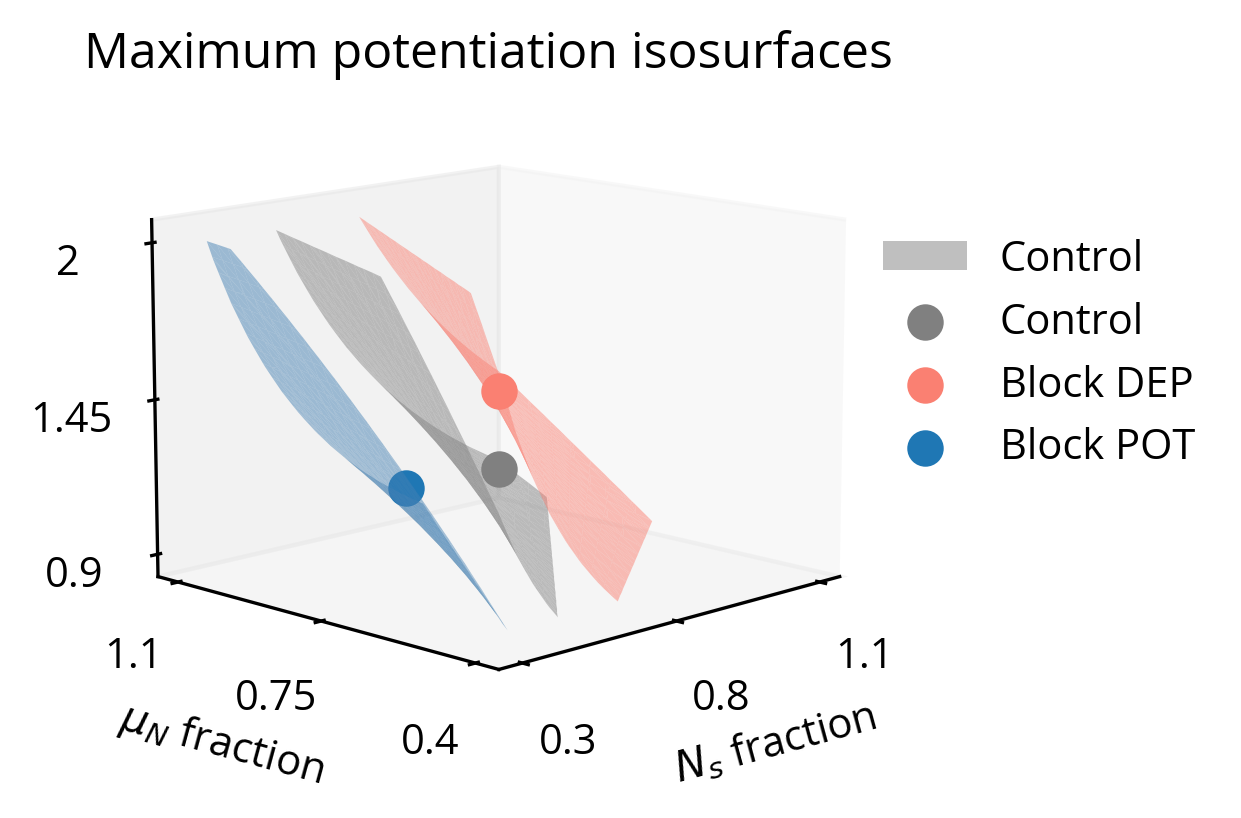

In [21]:
fig, ax = plt.subplots(1,1, figsize=(4.4,3), dpi=300, subplot_kw=dict(projection='3d'))
fig.subplots_adjust(top=0.95, right=0.7)
ax.view_init(12,225,0)

verts, faces, _, _ = marching_cubes(change_after_stim, level=1)
mesh = Poly3DCollection(verts[faces], alpha=0.5, color='gray', edgecolor='none', label='Control')
ax.add_collection3d(mesh)
ax.scatter(17, 17, 2, s=60, c='gray', label='Control')


verts, faces, _, _ = marching_cubes(change_after_stim, level=0.78)
mesh = Poly3DCollection(verts[faces], alpha=0.5, color='salmon', edgecolor='none')
ax.add_collection3d(mesh)
ax.scatter(2, 2, 13, s=60, c='salmon', label='Block DEP')

verts, faces, _, _ = marching_cubes(change_after_stim, level=1.3)
mesh = Poly3DCollection(verts[faces], alpha=0.5, color='steelblue', edgecolor='none')
ax.add_collection3d(mesh)
ax.scatter(9,15,3, s=60, label='Block POT')

ax.legend(frameon=False, loc=(1.,0.4), fontsize=10)

ax.grid(False)
ax.set_xticks([0,9.5,19],[0.3,0.8,1.1])
ax.set_yticks([0,9.5,19],[0.4,0.75,1.1])
ax.set_zticks([0,9.5,19],[0.9,1.45,2])

ax.set_title('Maximum potentiation isosurfaces', y=1.)
ax.set_xlabel(r'$N_s$ fraction', fontsize=10)
ax.set_ylabel(r'$\mu_N$ fraction', fontsize=10)
ax.set_zlabel(r'$\mu_K$ fraction', fontsize=10)

# plt.savefig('docs/figures-paper/single-panels/figure-4-level-curves.png', dpi=300)
# plt.savefig('docs/figures-paper/single-panels/figure-4-level-curves.svg', dpi=300)

In [22]:
simulation = Simulation(model = model,
                        model_p_dict = model_p_dict,
                        simulation_time = simulation_time,
                        spine_number = spine_number,
                        inter_spine_distance = inter_spine_distance,
                        stim_indexes = stim_idxes)

bsb, _, rsb = simulation.run(n_experiments)

scbs = bsb[2,:,0].flatten()
scdf = make_df_from_batch(rsb, stim_idxes)

# # fk506 run
fk_model_p_dict = deepcopy(model_p_dict)
fk_model_p_dict['tau_N'] *= .9

fk_model_p_dict['mu_log_K_N'][0] += log(1.2)
fk_model_p_dict['mu_log_K_N'][1] -= log(1.2)
fk_model_p_dict['sigma_N'] /=1.1
fk_model_p_dict['Ns'] /= 1.8

simulation = Simulation(model = model,
                        model_p_dict = fk_model_p_dict,
                        simulation_time = simulation_time,
                        spine_number = spine_number,
                        inter_spine_distance = inter_spine_distance,
                        stim_indexes = stim_idxes)

bsb, _, rsb = simulation.run(n_experiments)

sfkbs = bsb[2,:,0].flatten()

sfkdf = make_df_from_batch(rsb, stim_idxes)


# control onuma run
simulation = Simulation(model = model,
                        model_p_dict = model_p_dict,
                        simulation_time = simulation_time,
                        spine_number = spine_number,
                        inter_spine_distance = inter_spine_distance,
                        stim_indexes = ostim_idxes)

bsb, _, rsb = simulation.run(20)

scodf = make_df_from_batch(rsb, ostim_idxes)


# fk onuma run
ofk_model_p_dict = deepcopy(model_p_dict)
ofk_model_p_dict['Ns'] /= 2.5

ofk_model_p_dict['mu_log_K_N'][1] -= log(1.8)
ofk_model_p_dict['mu_log_K_N'][0] += log(1.8)

simulation = Simulation(model = model,
                        model_p_dict = ofk_model_p_dict,
                        simulation_time = simulation_time,
                        spine_number = spine_number,
                        inter_spine_distance = inter_spine_distance,
                        stim_indexes = ostim_idxes)

bsb, _, rsb = simulation.run(20)

sfkodf = make_df_from_batch(rsb, ostim_idxes)

Parse the simulated data for plotting

In [23]:
sYc = scdf[scdf['distance']==0].mean()
sYc_sem = scdf[scdf['distance']==0].sem()

sYfk = sfkdf[sfkdf['distance']==0].mean()
sYfk_sem = sfkdf[sfkdf['distance']==0].sem()

sYoc = scodf[scodf['distance']==0].mean()
sYoc_sem = scodf[scodf['distance']==0].sem()

sYofk = sfkodf[sfkodf['distance']==0].mean()
sYofk_sem = sfkodf[sfkodf['distance']==0].sem()

In [24]:
def custom_boxplot(ax, ctl_data, alt_data, **kwargs):

    ax.boxplot(ctl_data,
               widths=0.5,
               showfliers=False,
               boxprops=dict(color=kwargs.get('ctl_color'), linewidth=2),
               medianprops=dict(color='black', linewidth=2),
               whiskerprops=dict(color=kwargs.get('ctl_color'), linewidth=2),
               capprops=dict(color=kwargs.get('ctl_color'), linewidth=2),
               )

    ax.boxplot(alt_data,
               positions=(2,),
               widths=0.5,
               showfliers=False,
               boxprops=dict(color=kwargs.get('alt_color'), linewidth=2),
               medianprops=dict(color='black', linewidth=2),
               whiskerprops=dict(color=kwargs.get('alt_color'), linewidth=2),
               capprops=dict(color=kwargs.get('alt_color'), linewidth=2),
               )

    stripplot(ax,
              (ctl_data, alt_data),
              jitter=0.3, s= 1, alpha=0.1, c='gray')


    # Compute the differences between means
    a, da = ctl_data.mean(), ctl_data.std()/np.sqrt(len(ctl_data))
    b, db = alt_data.mean(), ctl_data.std()/np.sqrt(len(alt_data))

    d = (b-a)/a *100
    dd = (a*db + b*da) / a**2 * 100

    y_bar = 28000
    off_bar = 1000
    ax.plot((1,1,2,2,), (y_bar-off_bar, y_bar, y_bar, y_bar-off_bar), c='black')
    ax.text(1.5, y_bar-off_bar, '***', ha='center', va='top')
    ax.text(1.5, y_bar+off_bar, r'$({:.0f} \pm {:.0f})\%$'.format(d, dd),
            ha='center', va='bottom')

    # Cosmetics
    ax.set_xlabel('Condition', fontsize=12, labelpad=5)
    
    ax.set_ylim(-3000,40000)
    ax.set_xticks([1,2], kwargs.get('xticklabels'), fontsize=10)
    ax.ticklabel_format(axis='y', scilimits=(10,100))
    ax.set_ylabel('Spine size [a.u.]', fontsize=12)


def custom_time_plot(ax, ctl_data, alt_data, **kwargs):
    ax.errorbar(*ctl_data, c=kwargs.get('ctl_color'), label=kwargs.get('ctl_label'), linewidth=2)
    ax.errorbar(*alt_data, c=kwargs.get('alt_color'), label=kwargs.get('alt_label'), linewidth=2)
    ax.axhline(y=1, c='gray', linestyle=(0,(3,3)), linewidth=1)

    ax.legend(frameon=False, loc='upper left', fontsize=10)

    # ax.set_title('Plasticity at\nstimulated spine')
    ax.set_xlabel(r'Time [min]', fontsize=12)
    ax.set_ylabel('Post-basal ratio', fontsize=12)



def custom_space_plot(ax, ctl_df, alt_df, t_idx, **kwargs):

    # Check that the colors are compatible
    if not (kwargs.get('ctl_color') and kwargs.get('alt_color')):
        colors = ('gray', 'black')
    else: 
        colors = (kwargs.get('ctl_color'), kwargs.get('alt_color'))

    # Check the bins for the simulated data
    binss = kwargs.get('binss') or [[-1,0,1,2,3,4],[-3,-2,-1,0,1,2,3,4]]

    # Check the labels
    labels = (kwargs.get('ctl_label'), kwargs.get('alt_label'))

    for df, color, bins, label in zip((ctl_df, alt_df), colors, binss, labels):

        isd = mean_is_distance(df)
        # understand which subroutine to use (simulated dataframe is different from
        # the expeirmental one)
        
        if 'drug' in df.columns: # experimental branch
            binned_df = pd_bin_by_distance(df[df['distance']<6], 'norm_RID', isd)
            X = binned_df['distance']
            Y = binned_df['mean'].apply(lambda x: x[t_idx])
            Y_sem = binned_df['stderr'].apply(lambda x: x[t_idx])
        
        else:
            binned_df = average_sdf_across_distances(df, bins, t_idx)
            X = binned_df['X']
            Y = binned_df['Y']
            Y_sem = binned_df['Y_sem']
            
        ax.errorbar(X, Y, Y_sem, linestyle='-', c=color, linewidth=2, label=label)

    ax.axhline(y=1, c='gray', linestyle=(0,(3,3)), linewidth=1)

    ax.legend(frameon=False, loc='upper left', fontsize=10)

    # ax.set_title('Spatial profile\n at 2 min')
    ax.set_xlabel('Distance '+r'$[\mu m]$', fontsize=12)
    ax.set_ylabel('Post-basal ratio', fontsize=12)


In [25]:
def draw_paper_figure(subfigs):

    rows = []
        
    ############
    # Goda row #
    ############

    axs = subfigs[0].subplots(1,4)
    rows.append(axs)
    # subfigs[0].subplots_adjust(wspace=0.5, left=0.1, right=1)

    # Basal distributions
    custom_boxplot(
        axs[0],
        (cdf['RID'].apply(lambda x: x[0])),
        (fkdf['RID'].apply(lambda x: x[0])),
        ctl_color=ctl_color, alt_color=alt_color,
        xticklabels=('Control', 'FK506')
    )

    # Stimulated spine in time
    ax = axs[1]
    custom_time_plot(
        ax,
        (T, Yc, Yc_sem), (T, Yfk, Yfk_sem),
        ctl_color=ctl_color, alt_color=alt_color,
        ctl_label='Control', alt_label='FK506',
    )


    # Plasticity profile at 2 minutes
    ax = axs[2]
    custom_space_plot(
        ax, cdf, fkdf, 3,
        ctl_label='Control', alt_label='FK506'
    )

    # Plasticity profile at 30 minutes
    ax = axs[3]
    custom_space_plot(
        ax, cdf, fkdf, 6,
        ctl_label='Control', alt_label='FK506',    
    )


    #################
    # Simulated row #
    #################
    axs = subfigs[1].subplots(1,4)
    rows.append(axs)

    # Basal distributions
    custom_boxplot(
        axs[0],
        scbs,sfkbs,
        ctl_color=s_ctl_color, alt_color=s_alt_color,
        xticklabels=('Control', n_block_1_lab),
    )

    # Stimulated spine in time
    ax = axs[1]
    custom_time_plot(
        ax, (sT, sYc.loc[sT], sYc_sem.loc[sT]), (sT, sYfk.loc[sT], sYfk_sem.loc[sT]),
        ctl_color=s_ctl_color, alt_color=s_alt_color,
        ctl_label='Control', alt_label=n_block_1_lab,
    )
    ax.plot([-15,-10,-5,2], [1,1,1,sYc.loc[2]], c=s_ctl_color)
    ax.plot([-15,-10,-5,2], [1,1,1,sYfk.loc[2]], c=s_alt_color)

    # Plasticity profile at 2 minutes
    ax = axs[2]
    custom_space_plot(
        ax, scdf, sfkdf, 2,
        ctl_color=s_ctl_color, alt_color=s_alt_color,
        ctl_label='Control', alt_label=n_block_1_lab,
    )

    # Plasticity profile at 30 minutes
    ax = axs[3]
    custom_space_plot(
        ax, scdf, sfkdf, 30,
        ctl_color=s_ctl_color, alt_color=s_alt_color,
        ctl_label='Control', alt_label=n_block_1_lab,
    )



    #############
    # Onuma row #
    #############

    axs = subfigs[2].subplots(1,5,width_ratios=(0.1,2,2,2.5,0.1))

    for ax in axs[[0,-2,-1]]: ax.remove()

    rows.append(axs)
    # Onuma time
    ax = axs[1]
    custom_time_plot(
        ax,
        (codf['T']-31, codf['Y'], codf['Y_sem']),
        (fkodf['T']-31, fkodf['Y'], fkodf['Y_sem']),
        ctl_color=ctl_color, alt_color=alt_color,
        ctl_label='Control', alt_label='FK506',        
    )

    # Sim time
    ax = axs[2]
    custom_time_plot(ax,
        (osT, sYoc.loc[osT], sYoc_sem.loc[osT]),
        (osT, sYofk.loc[osT], sYofk_sem.loc[osT]),
        ctl_color=s_ctl_color, alt_color=o_s_alt_color,
        ctl_label='Control', alt_label=n_block_2_lab,
    )
    ax.plot([-10,0,2], [1,1,sYoc.loc[2]], c=s_ctl_color)
    ax.plot([-10,0,2], [1,1,sYofk.loc[2]], c=o_s_alt_color)


    # Formatting
    for ax in rows[0][1:]: ax.set_ylim(0.7, 3)
    for ax in rows[1][1:]: ax.set_ylim(0.7, 3)
    
    rows[2][1].set_ylim(0.7,3.2)
    rows[2][2].set_ylim(0.7,2.5)


    return rows    

/home/janko/code/phd/rdn-project/test-env/lib/python3.13/site-packages/rdn/defaults/pdbinbydistance.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_dff = dff.groupby('bin').agg({
/home/janko/code/phd/rdn-project/test-env/lib/python3.13/site-packages/rdn/defaults/pdbinbydistance.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_dff = dff.groupby('bin').agg({
/home/janko/code/phd/rdn-project/test-env/lib/python3.13/site-packages/rdn/defaults/pdbinbydistance.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obse

Text(0.5, 1.0, 'Plasticity evolution\nof stimulated spine')

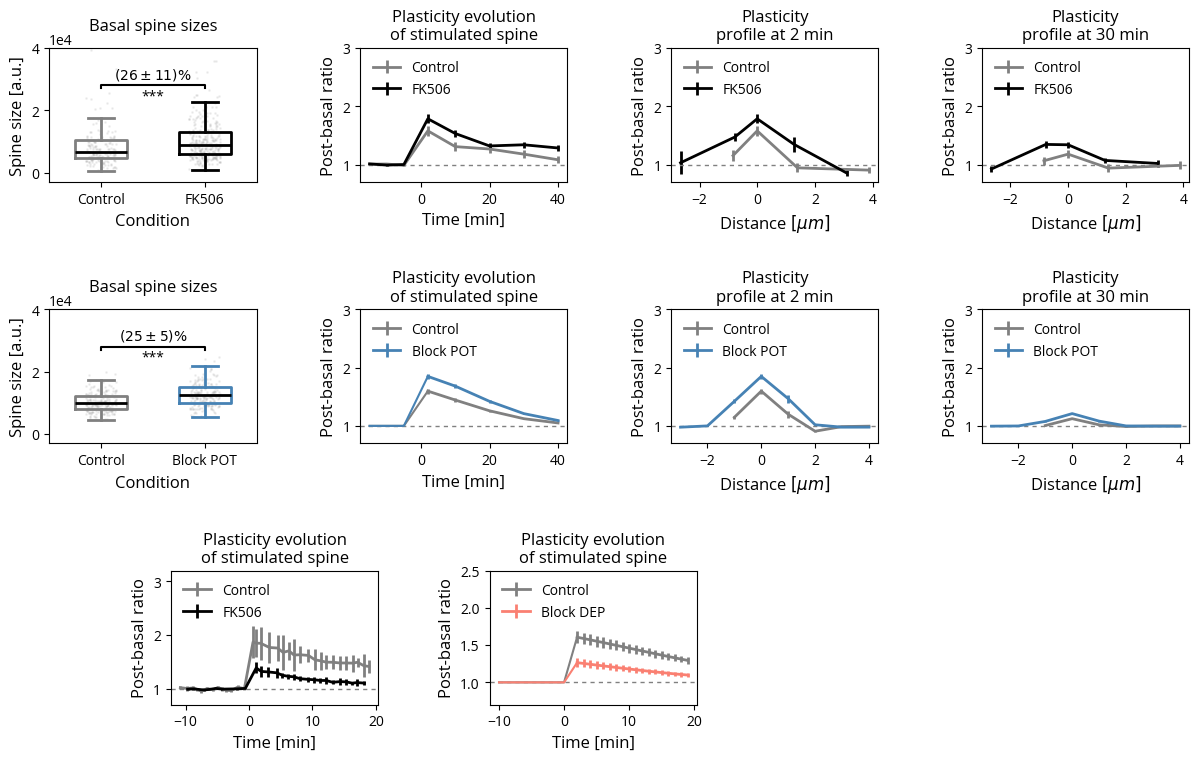

In [27]:
# some global cosmetics
ctl_color = 'gray'
alt_color= 'black'
s_ctl_color = 'gray'
s_alt_color = 'steelblue'
o_s_alt_color = 'salmon'
n_block_1_lab = 'Block POT'
n_block_2_lab = 'Block DEP'


fig = plt.figure(figsize=(12,7.5))
fig.subplots_adjust(left=0.04, bottom=0.21, right=0.99, top=0.8, wspace=0.5)

subfigs = fig.subfigures(3,1, hspace=0.15)

rows = draw_paper_figure(subfigs)

subfigs[2].subplots_adjust(wspace=.8)

rows[0][0].set_title('Basal spine sizes', pad=13)
rows[0][1].set_title('Plasticity evolution\nof stimulated spine')
rows[0][2].set_title('Plasticity\nprofile at 2 min')
rows[0][3].set_title('Plasticity\nprofile at 30 min')


rows[1][0].set_title('Basal spine sizes', pad=13)
rows[1][1].set_title('Plasticity evolution\nof stimulated spine')
rows[1][2].set_title('Plasticity\nprofile at 2 min')
rows[1][3].set_title('Plasticity\nprofile at 30 min')

# rows[2][3].set_title('Phosphatase block\nphase space')
rows[2][1].set_title('Plasticity evolution\nof stimulated spine')
rows[2][2].set_title('Plasticity evolution\nof stimulated spine')

# plt.savefig('docs/figures-paper/single-panels/figure-4-profiles.png', dpi=300)
# plt.savefig('docs/figures-paper/single-panels/figure-4-profiles.svg', dpi=300)

# Comparison with Oh 2014 (not included in the paper)

In [28]:
from rdn.defaults import stripplot
from scipy.stats import ttest_ind, kruskal

In [29]:
test_stim_idxes = ostim_idxes
n_cells = 20

# Zito basal experiment

zito_model_p_dict = deepcopy(model_p_dict)
zito_model_p_dict['Ks'] *= 1.
zito_model_p_dict['Ns'] *= 1


simulation = Simulation(model = model,
                        model_p_dict = zito_model_p_dict,
                        simulation_time = simulation_time,
                        spine_number = spine_number,
                        inter_spine_distance = inter_spine_distance,
                        stim_indexes = ostim_idxes)

bsb, _, rsb = simulation.run(n_cells, seed=2021)

sfkdf_zito = make_df_from_batch(rsb, test_stim_idxes)


# Try the zito experiment
zito_fk_model_p_dict = deepcopy(zito_model_p_dict)
zito_fk_model_p_dict['mu_log_K_N'][1] -= log(1.2)
zito_fk_model_p_dict['mu_log_K_N'][0] += log(1.2)
zito_fk_model_p_dict['sigma_N'] /=1.1
zito_fk_model_p_dict['Ns'] /= 1.8


simulation = Simulation(model = model,
                        model_p_dict = zito_fk_model_p_dict,
                        simulation_time = simulation_time,
                        spine_number = spine_number,
                        inter_spine_distance = inter_spine_distance,
                        stim_indexes = ostim_idxes)

bsb, _, rsb = simulation.run(n_cells)

sfkdf_zito_fk = make_df_from_batch(rsb, test_stim_idxes)

In [30]:
hetero_idxes = [98,99,101,102]

control_homo = sfkdf_zito.loc[100][2]
control_hetero = sfkdf_zito.loc[hetero_idxes][2]

fk_homo = sfkdf_zito_fk.loc[100][2]
fk_hetero = sfkdf_zito_fk.loc[hetero_idxes][2]

print(f'Testing differences: n={n_cells}\n')
print(f'=> Test: 2-tailed T-test')
print(f'   Homosynaptic {ttest_ind(control_homo, fk_homo).pvalue}')
print(f'   Heterosynaptic {ttest_ind(control_hetero, fk_hetero).pvalue}\n')
print(f'=> Test: Kruskal-Wallis')
print(f'   Homosynaptic {kruskal(control_homo, fk_homo).pvalue}')
print(f'   Heterosynaptic {kruskal(control_hetero, fk_hetero).pvalue}')

Testing differences: n=20

=> Test: 2-tailed T-test
   Homosynaptic 0.022104414370658236
   Heterosynaptic 3.5514977955142567e-09

=> Test: Kruskal-Wallis
   Homosynaptic 0.008693986098127389
   Heterosynaptic 5.933570116266156e-11


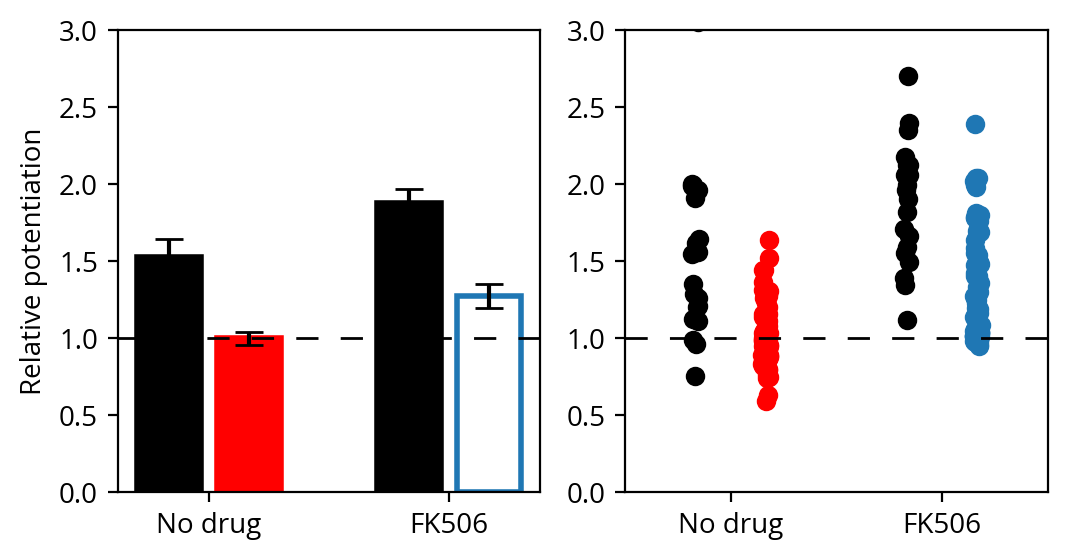

In [31]:
cho_mean = control_homo.mean()
cho_sem = control_homo.std()/np.sqrt(n_cells)

che_mean = control_hetero.mean()
che_sem = control_hetero.std()/np.sqrt(n_cells)

fkho_mean = fk_homo.mean()
fkho_sem = fk_homo.std()/np.sqrt(n_cells)

fkhe_mean = fk_hetero.mean()
fkhe_sem = fk_hetero.std()/np.sqrt(n_cells)

fig, axs = plt.subplots(1,2, figsize=(6,3), dpi=200)
ax = axs[0]
ax.bar(
    (1,2,4,5),
    (cho_mean, che_mean, fkho_mean, fkhe_mean),
    yerr=(cho_sem, che_sem, fkho_sem, fkhe_sem),
    color=('black', 'red', 'black', 'white'),
    edgecolor=('black', 'red', 'black', 'tab:blue'),
    linewidth=2,
    capsize=5,
)
ax.axhline(y=1, linestyle=(0,(8,8)), c='black', linewidth=1)

ax.set_ylim(0,3)
ax.set_xticks(
    [1.5,4.5],
    ['No drug', 'FK506']
)
ax.set_ylabel('Relative potentiation')


ax = axs[1]
stripplot(
    ax=ax,
    x=(1,2,4,5),
    datas=(control_homo, control_hetero, fk_homo, fk_hetero),
    colors=('black', 'red', 'black', 'tab:blue')
)
ax.axhline(y=1, linestyle=(0,(8,8)), c='black', linewidth=1)

ax.set_xlim(1,7)
ax.set_ylim(0,3)
ax.set_xticks(
    [2.5,5.5],
    ['No drug', 'FK506']
)

for ax in axs: ax.set_yticks([0,0.5,1,1.5,2,2.5,3])


Quick visualization of the experiment

In [32]:
def quick_plot_series(df):
    means = df.groupby(df.index).apply('mean')
    sems = df.groupby(df.index).apply('std')/np.sqrt(13)
    X = np.arange(97,104)
    Y_2_min = means.loc[X][2]
    Y_sem_2_min = sems.loc[X][2]

    return X, Y_2_min, Y_sem_2_min

X, ZY, ZYsem = quick_plot_series(sfkdf_zito)
X, ZY_fk, ZYsem_fk = quick_plot_series(sfkdf_zito_fk)

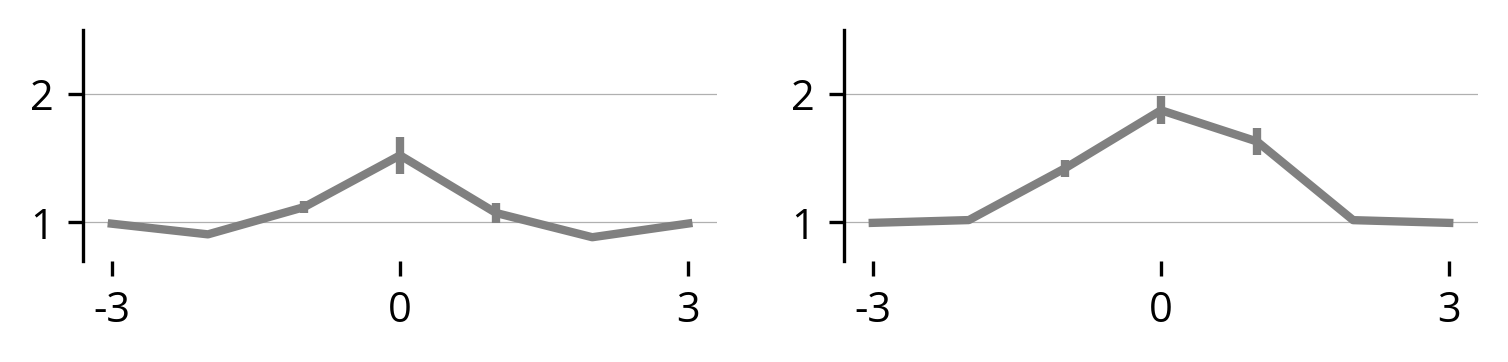

In [33]:
fig, axs = plt.subplots(1,2,figsize=(6,1), dpi=300)

ax = axs[0]
ax.errorbar(X, ZY, ZYsem, linewidth=2, c='gray')

ax = axs[1]
ax.errorbar(X, ZY_fk, ZYsem_fk,  linewidth=2, c='gray')

for ax in axs:
    ax.set_ylim(0.7,2.5)
    ax.set_xticks((97,100,103),(-3,0,3))
    for k, v in ax.spines.items():
        if k != 'left': v.set_visible(False)

    ax.grid(axis='y', linewidth=0.3)